In [37]:
import pickle
import os
import copy
import numpy as np

itr = 310
# samples_folder = "ppo-point-embed-tanh/ppo_point_embed_tanh_2018_08_21_19_27_48_0001"
samples_folder = "ppo-point-embed-makeplots/ppo_point_embed_makeplots_2018_08_21_19_59_46_0001"
samples_folder = "sawyer-reach-embed-tanh/sawyer_reach_embed_tanh_2018_08_21_19_31_34_0001"
samples_folder = "sawyer-reach-embed-notanh/sawyer_reach_embed_notanh_2018_08_23_12_38_13_0001"
# samples_folder = "sawyer-push-embed/sawyer_push_embed_2018_08_23_12_50_24_0001"

samples_file = "samples_%i.pkl" % itr
data_dir = os.path.join(os.getcwd(), "../../../data/local")
with open(os.path.join(data_dir, samples_folder, samples_file), "rb") as fin:
    samples = pickle.load(fin)
samples.keys()
ntasks = samples["tasks"][0].shape[1]
tasks = {}
for i in range(len(samples["tasks"])):
    task = np.argmax(samples["tasks"][i][0])
    if not task in tasks:
        tasks[task] = [i]
    else:
        tasks[task].append(i)
task_nums = ", ".join("%i x task %i" % (len(tasks[task]), task) for task in range(ntasks))
print('Loaded %i trajectories (%s).' % (len(samples["tasks"]), task_nums))

Loaded 171 trajectories (21 x task 0, 21 x task 1, 20 x task 2, 21 x task 3, 21 x task 4, 22 x task 5, 23 x task 6, 22 x task 7).


Tasks: 8
Latents: 3


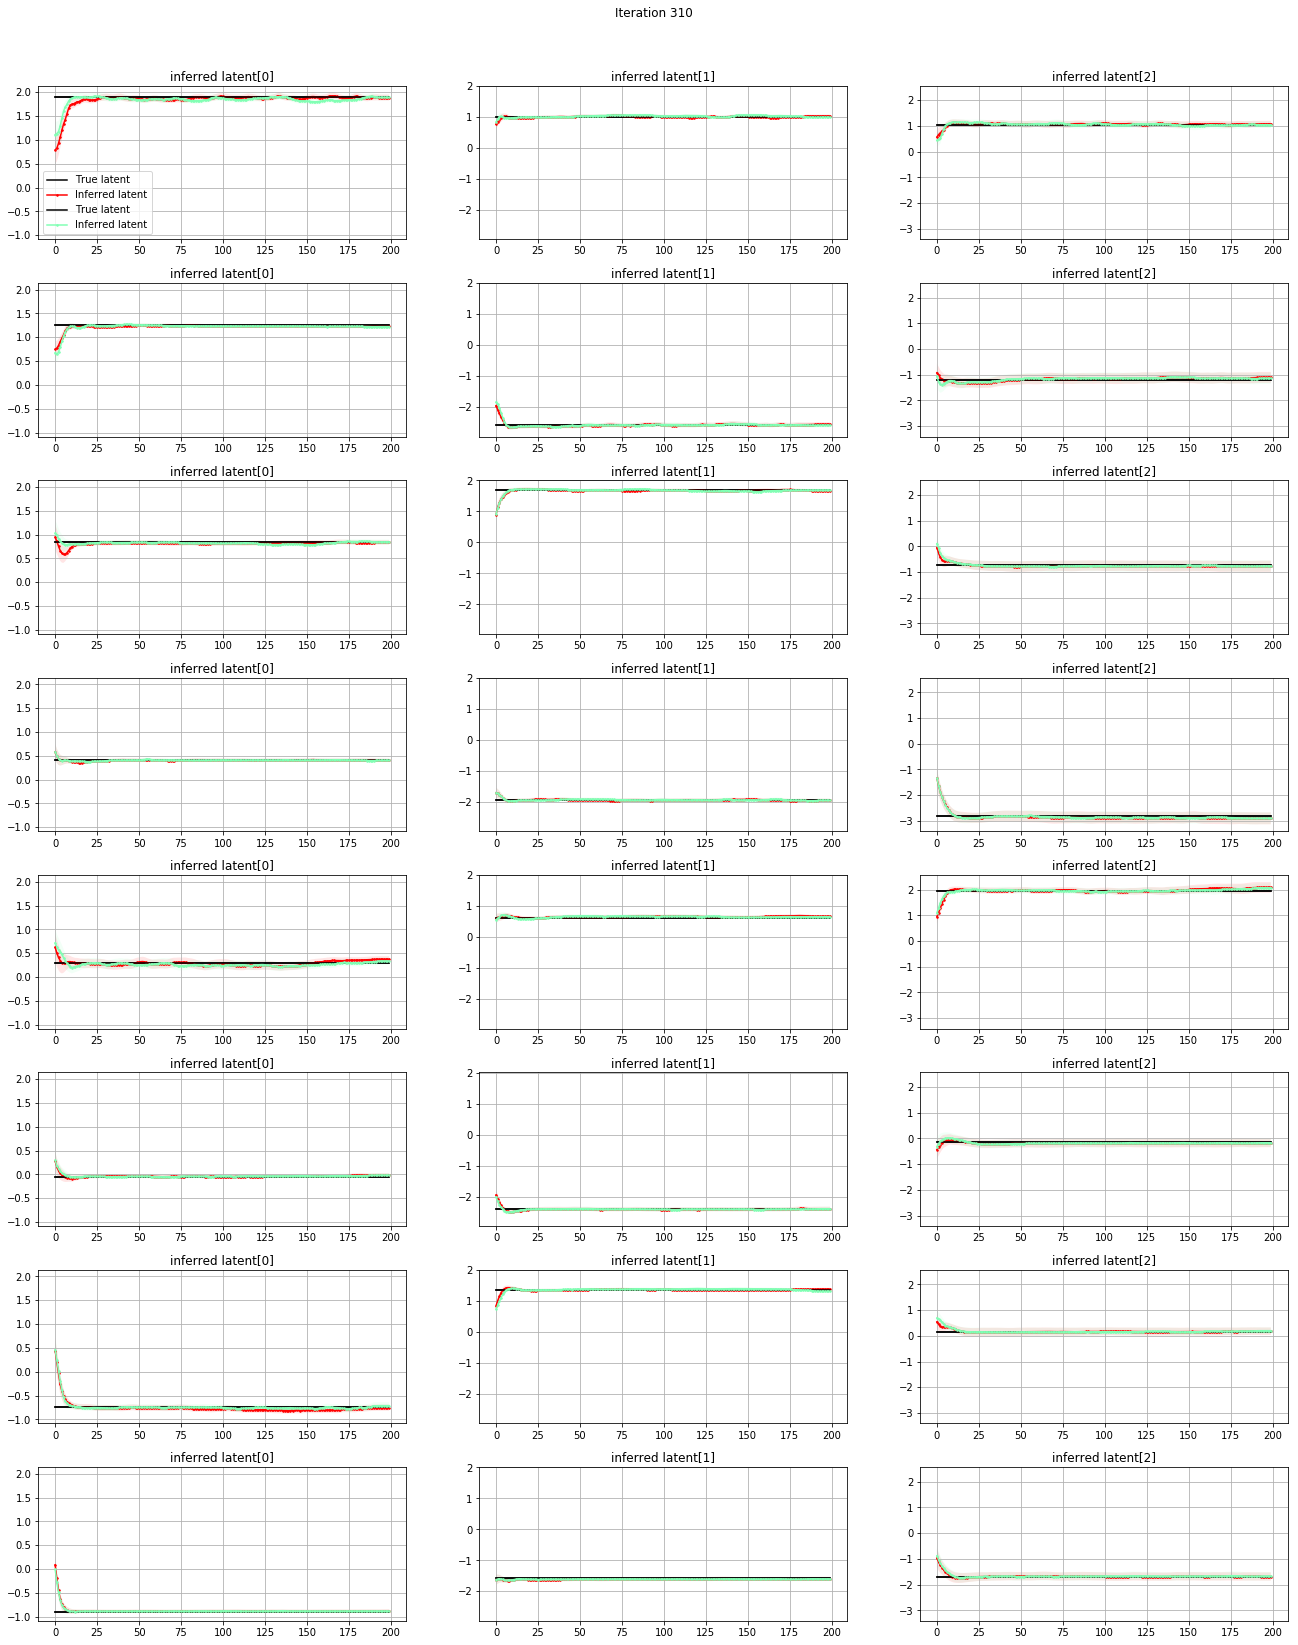

In [38]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

title = 'Iteration %i' % itr
ntasks = samples["tasks"][0].shape[1]
print("Tasks:", ntasks)
nlatents = samples["latents"][0].shape[1]
print("Latents:", nlatents)
nrollouts = 2
fig = plt.figure(figsize=(nlatents * 6, ntasks * 3))
fig.suptitle(title)

infer_axes = []
colormap = lambda x: matplotlib.cm.get_cmap("rainbow")(1. - x)

gs0 = gridspec.GridSpec(ntasks, 1)
for task in range(ntasks):
    gs00 = gridspec.GridSpecFromSubplotSpec(1, nlatents,
                                            subplot_spec=gs0[task])
    path_length = samples["latent_infos"]["mean"][tasks[task][0]].shape[0]
    xs = np.arange(0, path_length)
    for li in range(nlatents):
        infer_ax = plt.Subplot(fig, gs00[li])
        infer_ax.set_title("inferred latent[%i]" % li)
        infer_ax.grid()
        if task > 0:
            infer_ax.get_shared_x_axes().join(infer_ax, infer_axes[li])
            infer_ax.get_shared_y_axes().join(infer_ax, infer_axes[li])
        for i in range(nrollouts):
            embedding_mean = samples["latent_infos"]["mean"][tasks[task][i]][0]
            embedding_std = np.exp(samples["latent_infos"]["log_std"][tasks[task][i]][0])
            true_mu, true_sigma = embedding_mean[li], embedding_std[li]
            infer_ax.fill_between(xs,
                                  np.ones_like(xs) * (true_mu + 2.5 * true_sigma),
                                  np.ones_like(xs) * (true_mu - 2.5 * true_sigma),
                                  facecolor="lightgrey",
                                  alpha=.6,
                                  zorder=1)
            infer_ax.plot(xs, np.ones_like(xs) * true_mu, color="black", zorder=2, label="True latent")
        
            mus = samples["trajectory_infos"]["mean"][tasks[task][i]][:, li]
            sigmas = np.exp(samples["trajectory_infos"]["log_std"][tasks[task][i]][:, li])
            infer_ax.fill_between(xs,
                                  mus + sigmas,
                                  mus - sigmas,
                                  facecolor=colormap(i * 1. / nrollouts),
                                  alpha=.1,
                                  zorder=1)
            infer_ax.plot(xs, mus, color=colormap(i * 1. / nrollouts), marker='o', markersize=1.5, zorder=2,
                         label="Inferred latent")
        if task == 0 and li == 0:
            infer_ax.legend()
        infer_axes.append(infer_ax)
        fig.add_subplot(infer_ax)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig("inference_net_%i.png" % itr)

Tasks: 8
Latents: 3


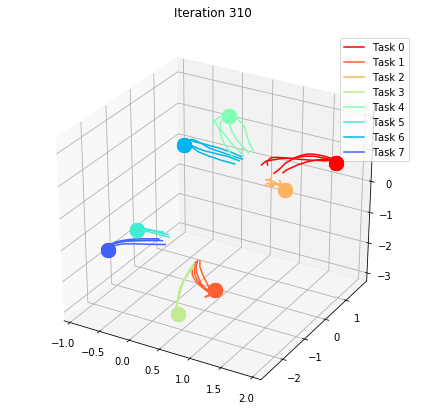

In [39]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

all_rollouts_in_one_plot = True

title = 'Iteration %i' % itr
ntasks = samples["tasks"][0].shape[1]
print("Tasks:", ntasks)
nlatents = samples["latents"][0].shape[1]
print("Latents:", nlatents)
nrollouts = 4

assert(nlatents == 2 or nlatents == 3)

infer_axes = []
colormap = lambda x: matplotlib.cm.get_cmap("rainbow")(1. - x)

if all_rollouts_in_one_plot:
    fig = plt.figure(figsize=(6, 6))
else:
    fig = plt.figure(figsize=(nrollouts * 6, 6))
    gs0 = gridspec.GridSpec(1, nrollouts)
fig.suptitle(title)
if all_rollouts_in_one_plot:
    if nlatents == 2:
        infer_ax = fig.add_subplot(111)      
    else:
        from mpl_toolkits import mplot3d
        infer_ax = fig.add_subplot(111, projection='3d')
    infer_ax.grid()
for i in range(nrollouts):
    if not all_rollouts_in_one_plot:
        if nlatents == 2:
            infer_ax = fig.add_subplot(gs0[i])      
        else:
            from mpl_toolkits import mplot3d
            infer_ax = fig.add_subplot(gs0[i], projection='3d')
        if i > 0:
            infer_ax.get_shared_x_axes().join(infer_ax, infer_axes[0])
            infer_ax.get_shared_y_axes().join(infer_ax, infer_axes[0])

        infer_ax.set_title("rollout %i" % (i+1))
        infer_ax.grid()
    for task in range(ntasks):
        if i >= len(tasks[task]):
            continue
        inferred_latent = samples["trajectory_infos"]["mean"][tasks[task][i]]
        true_latent = samples["latent_infos"]["mean"][tasks[task][i]][0]

        color = colormap(task * 1. / ntasks)    
        if nlatents == 2:            
            infer_ax.scatter([true_latent[0]], [true_latent[1]], s=200, zorder=2, c=color)
            infer_ax.plot(inferred_latent[:,0], inferred_latent[:,1], zorder=2,
                         label="Task %i" % task, c=color)
        else:
            infer_ax.scatter([true_latent[0]], [true_latent[1]], [true_latent[2]], s=200, zorder=2, c=color)
            infer_ax.plot(inferred_latent[:,0], inferred_latent[:,1], inferred_latent[:,2], zorder=2,
                         label="Task %i" % task, c=color)
    if i == 0:
        infer_ax.legend()
    infer_axes.append(infer_ax)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig("inference_net_%i.png" % itr)

In [40]:
def read_itr(s: str):
    return int(s[len("samples_"):-len(".pkl")])
    
from tqdm import tqdm_notebook as tqdm

files = sorted(list(filter(lambda s: s.startswith("samples_"), list(os.walk(os.path.join(data_dir, samples_folder)))[0][2])), key=read_itr)

aggregate = {
    "true_latent_means": [],
    "true_latent_stds": []
}
print("Reading %i file(s)..." % len(files))
num_traj = 0
for c, f in enumerate(tqdm(files)):
    with open(os.path.join(data_dir, samples_folder, f), "rb") as fin:
        samples = pickle.load(fin)
        tasks = {}
        for i in range(len(samples["tasks"])):
            task = np.argmax(samples["tasks"][i][0])
            if not task in tasks:
                tasks[task] = [i]
            else:
                tasks[task].append(i)
                
        if c == 0:
            num_traj = min(map(len, tasks.values()))
            aggregate["true_latent_means"] = np.zeros((len(tasks), num_traj, len(files), nlatents))
            print("Aggregate latent mean shape:", aggregate["true_latent_means"].shape)
        
        for task in tasks.keys():
            for i in range(num_traj):
                aggregate["true_latent_means"][task, i, c] = samples["latent_infos"]["mean"][tasks[task][i]][0]

Reading 64 file(s)...


Aggregate latent mean shape: (8, 16, 64, 3)



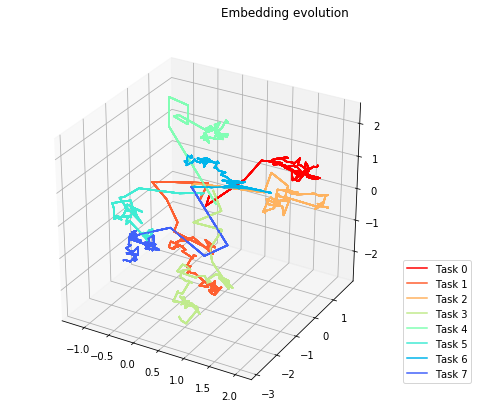

In [41]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

all_rollouts_in_one_plot = True

infer_axes = []
colormap = lambda x: matplotlib.cm.get_cmap("rainbow")(1. - x)

if all_rollouts_in_one_plot:
    fig = plt.figure(figsize=(6+2, 6))
else:
    fig = plt.figure(figsize=(num_traj * 6 + 2, 6))
    gs0 = gridspec.GridSpec(1, num_traj)
fig.suptitle("Embedding evolution")
if all_rollouts_in_one_plot:
    if nlatents == 2:
        infer_ax = fig.add_subplot(111)      
    else:
        from mpl_toolkits import mplot3d
        infer_ax = fig.add_subplot(111, projection='3d')
    infer_ax.grid()
for i in range(num_traj):
    if not all_rollouts_in_one_plot:
        if nlatents == 2:
            infer_ax = fig.add_subplot(gs0[i])      
        else:
            from mpl_toolkits import mplot3d
            infer_ax = fig.add_subplot(gs0[i], projection='3d')
        if i > 0:
            infer_ax.get_shared_x_axes().join(infer_ax, infer_axes[0])
            infer_ax.get_shared_y_axes().join(infer_ax, infer_axes[0])

        infer_ax.set_title("rollout %i" % (i+1))
        infer_ax.grid()
    for task in range(ntasks):
        if i >= len(tasks[task]):
            continue
#         inferred_latent = samples["trajectory_infos"]["mean"][tasks[task][i]]
        true_latent = aggregate["true_latent_means"][task, i]

        color = colormap(task * 1. / ntasks)    
        if nlatents == 2:            
#             infer_ax.scatter([true_latent[0]], [true_latent[1]], s=200, zorder=2, c=color)
            infer_ax.plot(true_latent[:,0], true_latent[:,1], zorder=2,
                         label="Task %i" % task, c=color)
        else:
#             infer_ax.scatter([true_latent[0]], [true_latent[1]], [true_latent[2]], s=200, zorder=2, c=color)
            infer_ax.plot(true_latent[:,0], true_latent[:,1], true_latent[:,2], zorder=2,
                         label="Task %i" % task, c=color)
    if i == 0:
        infer_ax.legend(bbox_to_anchor=(1.2, .4))
    infer_axes.append(infer_ax)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig("%i_embedding_evolution.png" % itr)

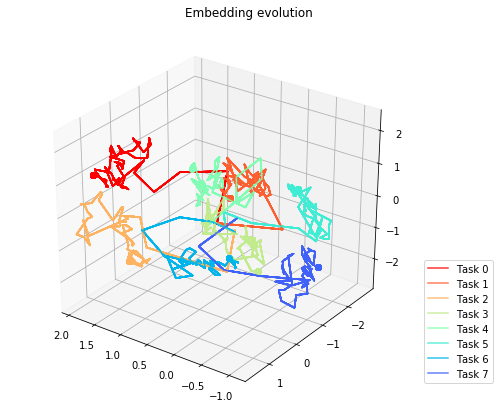

In [42]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.animation as animation

infer_axes = []
colormap = lambda x: matplotlib.cm.get_cmap("rainbow")(1. - x)

fig = plt.figure(figsize=(6 + 1, 6))

fig.suptitle("Embedding evolution")
if nlatents == 2:
    infer_ax = fig.add_subplot(111)      
else:
    from mpl_toolkits import mplot3d
    infer_ax = fig.add_subplot(111, projection='3d')
infer_ax.grid()

def update_line(num, plots):
    c = 0
    scatter_i = len(plots) // 2
    for i in range(num_traj):
        for task in range(ntasks):
            if i >= len(tasks[task]):
                continue
            true_latent = aggregate["true_latent_means"][task, i]
            plots[c].set_data(true_latent[:num, :2].T)
            plots[c].set_3d_properties(true_latent[:num, 2])
            c += 1
            plots[c].set_data(true_latent[num, :2].T)
            plots[c].set_3d_properties(true_latent[num, 2])
            c += 1
    infer_ax.view_init(elev=30, azim=num*2)
    return plots

plots = []
for i in range(num_traj):
    for task in range(ntasks):        
        color = colormap(task * 1. / ntasks)    
        if nlatents == 2:  
            l, = infer_ax.plot([], [], c=color, label=(("Task %i" % task) if i == 0 else None), alpha=0.8)
            s, = infer_ax.plot([], [], c=color, marker='o')
        else:
            l, = infer_ax.plot([], [], [], c=color, label=(("Task %i" % task) if i == 0 else None), alpha=0.8)
            s, = infer_ax.plot([], [], [], c=color, marker='o')
        plots.append(l)
        plots.append(s)
    
infer_ax.legend(bbox_to_anchor=(1.2, .4))
# infer_ax.set_xlim(-1, 1)
# infer_ax.set_ylim(-1, 1)
# infer_ax.set_zlim(-1, 1)
xyzs = aggregate["true_latent_means"].reshape((-1, nlatents))
min_em = np.min(xyzs, axis=0)
max_em = np.max(xyzs, axis=0)
infer_ax.set_xlim(min_em[0], max_em[0])
infer_ax.set_ylim(min_em[1], max_em[1])
infer_ax.set_zlim(min_em[2], max_em[2])
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

line_ani = animation.FuncAnimation(fig, update_line, len(files), fargs=(plots,),
                                   interval=50, blit=True)
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
line_ani.save('evolution_%i.mp4' % len(files), writer=writer)
line_ani